In [ ]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neural_network import MLPClassifier
import math
import matplotlib.pyplot as plt
from sklearn import cluster, metrics, preprocessing
from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, LabelEncoder
import matplotlib.cm as cm
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
from google.colab import drive
import statsmodels.api as sm

drive.mount('/content/gdrive')

Mounted at /content/gdrive


### Cargar la información del CSV y convertir variables categoricas.

marital, job y contact pasan a convertirse por medio de one hot y el resto de variables categoricas por LabelEncoder (esto por el tamaño de valroes únicos o por ser ordinales). No hay variables con valores nulos

In [ ]:
data = pd.read_csv(r"/content/gdrive/My Drive/Colab Notebooks/data/bank_marketing.csv")

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9000 entries, 0 to 8999
Data columns (total 29 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   age                9000 non-null   float64
 1   education          9000 non-null   int64  
 2   default            9000 non-null   int64  
 3   balance            9000 non-null   float64
 4   housing            9000 non-null   int64  
 5   loan               9000 non-null   int64  
 6   day                9000 non-null   int64  
 7   month              9000 non-null   int64  
 8   duration           9000 non-null   float64
 9   campaign           9000 non-null   float64
 10  pdays              9000 non-null   float64
 11  previous           9000 non-null   float64
 12  poutcome           9000 non-null   int64  
 13  y                  9000 non-null   int64  
 14  marital_married    9000 non-null   uint8  
 15  marital_single     9000 non-null   uint8  
 16  job_blue-collar    9000 

In [ ]:
data.nunique()

age                    74
education               4
default                 2
balance              3476
housing                 2
loan                    2
day                    31
month                  12
duration             1327
campaign               34
pdays                 437
previous               31
poutcome                4
y                       2
marital_married         2
marital_single          2
job_blue-collar         2
job_entrepreneur        2
job_housemaid           2
job_management          2
job_retired             2
job_self-employed       2
job_services            2
job_student             2
job_technician          2
job_unemployed          2
job_unknown             2
contact_telephone       2
contact_unknown         2
dtype: int64

In [ ]:
numerical_data = data.select_dtypes(include=[np.number])
std_cols = numerical_data.columns.tolist()
std_cols.remove('day')

labeler = LabelEncoder()
data['default'] = labeler.fit_transform(data['default'])
data['education'] = labeler.fit_transform(data['education'])
data['housing'] = labeler.fit_transform(data['housing'])
data['loan'] = labeler.fit_transform(data['loan'])
data['month'] = labeler.fit_transform(data['month'])
data['poutcome'] = labeler.fit_transform(data['poutcome'])
data['y'] = labeler.fit_transform(data['y'])
oneHotColumns = ['marital', 'job', 'contact']
oneHot = pd.get_dummies(data.loc[:, oneHotColumns], drop_first=True)
data = pd.concat([data, oneHot], axis = 1)
data.drop(oneHotColumns, axis=1, inplace=True)

### Transform
data.age = np.log(data['age'].add(1 - data['age'].min()))
data.balance = np.log(data['balance'].add(1 - data['balance'].min()))
data.duration = np.log(data['duration'].add(1 - data['duration'].min()))
data.campaign = np.log(data['campaign'].add(1 - data['campaign'].min()))
data.pdays = np.log(data['pdays'].add(1 - data['pdays'].min()))
data.previous = np.log(data['previous'].add(1 - data['previous'].min()))

### Standardize
#scaler  = preprocessing.MinMaxScaler().set_output(transform='pandas')
#cols = ['age', 'balance', 'duration']
#st_df = scaler.fit_transform(data.loc[:, cols])
#data[cols] = st_df[cols]

data.head()

,age,education,default,balance,housing,loan,day,month,duration,campaign,...,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,job_unknown,contact_telephone,contact_unknown
0,2.639057,2,0,8.652598,0,0,10,9,5.755742,0.693147,...,0,0,1,0,0,0,0,0,0,0
1,2.484907,3,0,8.443116,0,0,6,11,5.493061,0.000000,...,0,0,0,0,0,0,1,0,0,0
2,3.178054,1,0,8.558527,1,0,17,9,5.905362,0.000000,...,0,0,0,0,0,0,0,0,0,0
3,3.496508,1,0,8.052933,1,0,17,5,2.772589,2.079442,...,0,0,0,0,0,0,0,0,0,0
4,3.135494,1,0,8.025843,0,0,28,5,6.202536,0.693147,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
def histograms(data: pd.DataFrame, columns: list[str]):
  cols = 3
  rows = -(-len(columns)//cols)
  rows = 1 if (rows == 0) else rows
  fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(100,40))

  for i in range(len(columns)):
    col = data[columns[i]]
    sns.kdeplot(x=col, ax=axs[(i // cols), (i % cols)], fill=True);

  plt.subplots_adjust(hspace=0.5, wspace=0.3)
  plt.show()

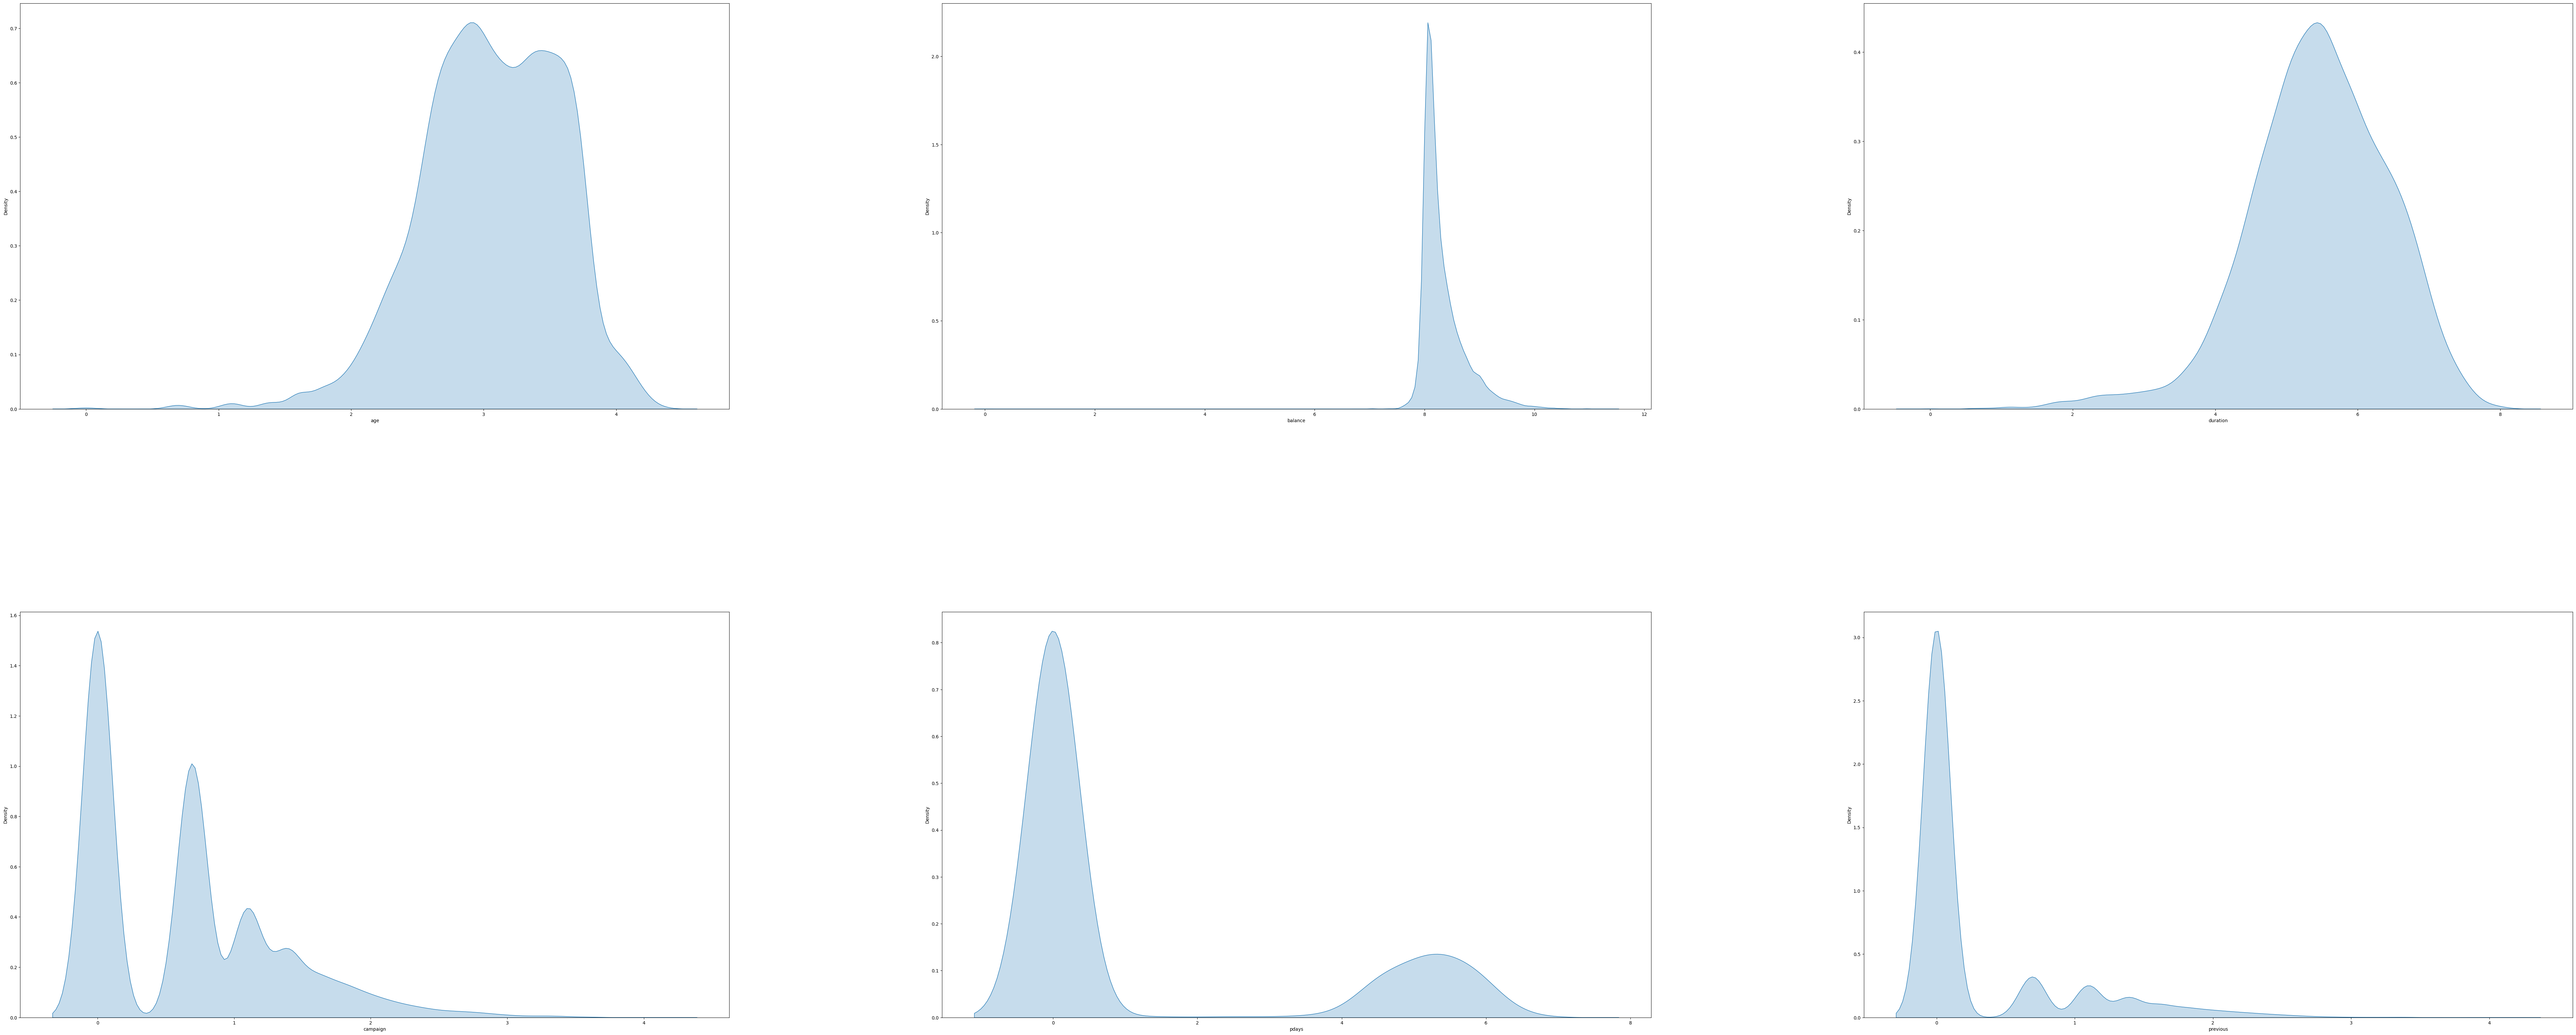

In [ ]:
histograms(data, std_cols)

### Separacion de datos de entrenamiento, prueba y validación

In [ ]:
train, redux = train_test_split(data, test_size=0.4)
valid, test = train_test_split(redux, test_size=0.5)

### Standardize fitting only the training data and then transform the test, validation and train
scaler = preprocessing.MinMaxScaler().set_output(transform='pandas')
cols = ['age', 'balance', 'duration']
train[cols] = scaler.fit_transform(train.loc[:, cols])
valid[cols] = scaler.transform(valid.loc[:, cols])
test[cols] = scaler.transform(test.loc[:, cols])

x_test = test.loc[:, test.columns != "y"].to_numpy()
x_valid = valid.loc[:, valid.columns != "y"].to_numpy()
x_train = train.loc[:, train.columns != "y"].to_numpy()

y_test = test.y.to_numpy()
y_valid = valid.y.to_numpy()
y_train = train.y.to_numpy()

In [ ]:
def logisticBest(x: np.ndarray, y: np.ndarray, x_test: np.ndarray, y_test: np.ndarray):
  parameters = {
      'C': [0.15, 0.1, 0.075, 0.05, 0.03],
      'penalty': ('l2', None),
      'solver': ('newton-cg', 'saga', 'lbfgs', 'sag'),
  }
  regression = LogisticRegression(max_iter=3000)
  regression_grid = GridSearchCV(regression, parameters)

  regression_grid.fit(x, y)
  print(f'mejores parametros : {regression_grid.best_params_}')
  print(f'exactitud con prueba: {regression_grid.score(x_test, y_test)}')
  params = regression_grid.best_params_
  return params['C'], params['penalty'], params['solver']

In [ ]:
C, penalty, solver = logisticBest(x_train, y_train, x_valid, y_valid)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and

mejores parametros : {'C': 0.15, 'penalty': None, 'solver': 'sag'}
exactitud con prueba: 0.815


In [ ]:
regression = LogisticRegression(max_iter=3000, penalty=penalty, solver=solver, C=C)
model_RL = regression.fit(x_train, y_train);
pr = model_RL.predict(x_test)
rl_confusion = metrics.confusion_matrix(y_test, pr)
rl_score = model_RL.score(x_test, y_test)

### Hay menos falsos positivos que falsos negativos, lo cuál predecira que más usuarios no se suscribiran al deposito fijo cuando en realidad si lo haran

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


In [ ]:
def bestClassifier(x: np.ndarray, y: np.ndarray, x_test: np.ndarray, y_test: np.ndarray, coeffs = [0.35, 0.5, 0.65, 0.8, 0.95]):
  neuronas = [i for i in range(10, 120, 10)]

  cols = 3
  rows = -(-len(coeffs)//cols)
  rows = 1 if (rows == 0) else rows
  fig, axs = plt.subplots(nrows=rows, ncols=cols, figsize=(100, 40))

  for i in range(len(coeffs)):
    alfa = coeffs[i]
    train_scores = list()
    test_scores = list()
    for j in neuronas:
      model = MLPClassifier(
        hidden_layer_sizes=(j, j // 4),
        max_iter=3000,
        alpha=alfa,
        random_state=24,
        early_stopping=True,
      )
      model.fit(x, y)

      train_yhat = model.predict(x)
      train_acc = 1 - np.mean(abs(y - train_yhat))
      train_scores.append(train_acc)

      train_yhat = model.predict(x_test)
      train_acc = 1 - np.mean(abs(y_test - train_yhat))
      test_scores.append(train_acc)

    ax = axs[i // cols, i % cols]
    ax.plot(neuronas, train_scores, '-o', label='Train')
    ax.plot(neuronas, test_scores, '-o', label='Test')
    ax.legend()
    ax.set_title(f'Alfa de {alfa}')
    ax.set_xlabel('neuronas de 2 capas ocultas')
    ax.set_ylabel('exactitud / accuracy')

  fig.show()

/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:693: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")


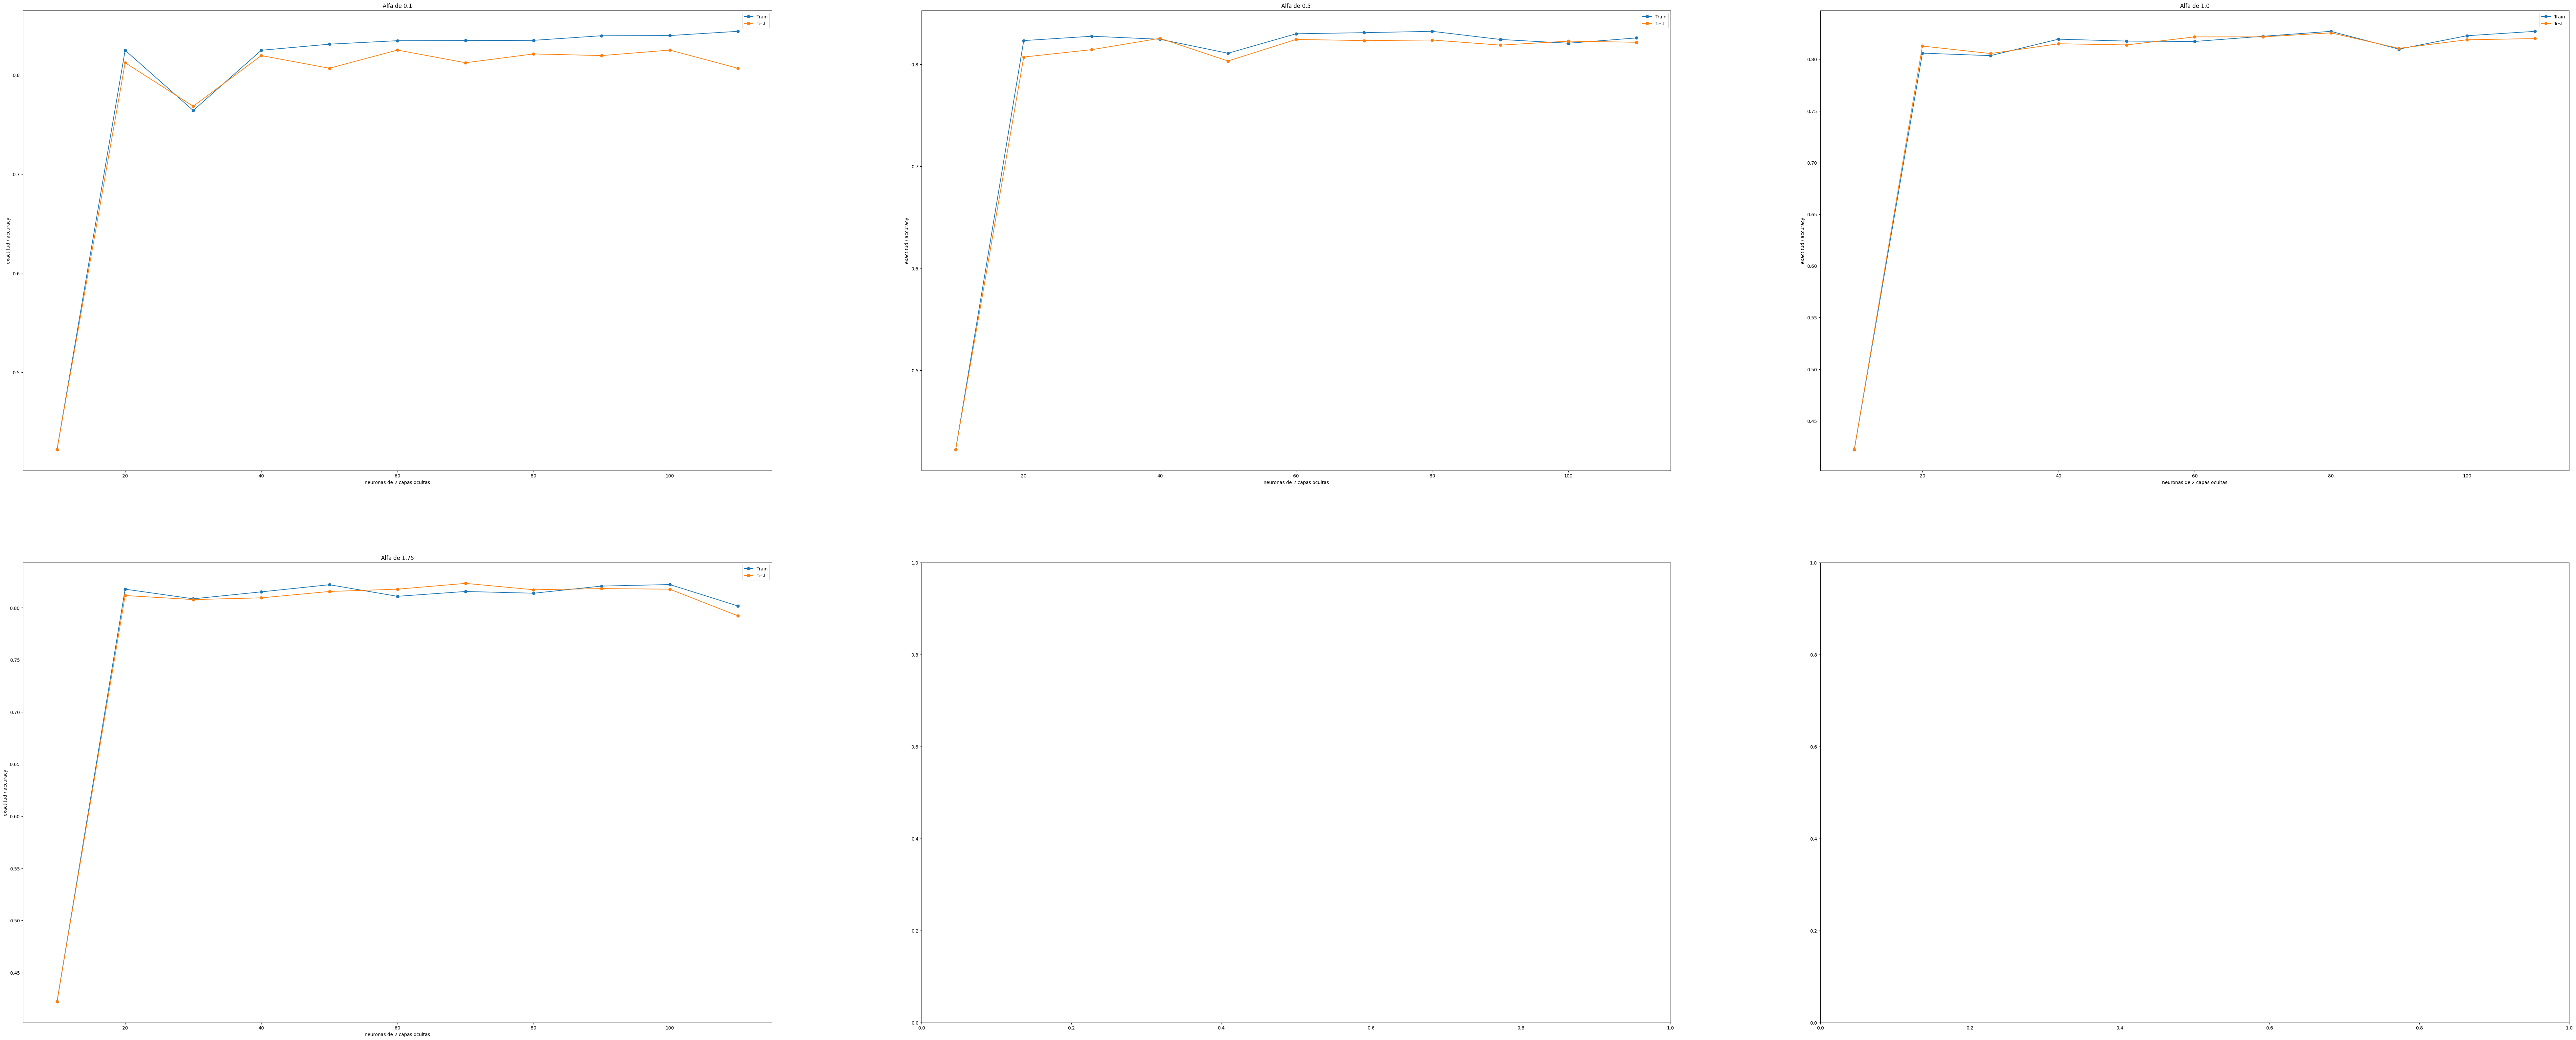

In [ ]:
bestClassifier(x_train, y_train, x_valid, y_valid, coeffs = [0.1, 0.5, 1.0, 1.75])

In [ ]:
model = MLPClassifier(
  hidden_layer_sizes=(100, 25),
  max_iter=3000,
  alpha=0.5,
  random_state=24,
  early_stopping=True,
)
model.fit(x_train, y_train)

pr = model.predict(x_test)

In [ ]:
neural_confusion = metrics.confusion_matrix(y_test, pr)
neural_score = model.score(x_test, y_test)

In [ ]:
print(f'score: {neural_score}, matrix: {neural_confusion}')
print(f'score: {rl_score}, matrix: {rl_confusion}')

score: 0.8038888888888889, matrix: [[897 156]
 [178 569]]
score: 0.815, matrix: [[898 155]
 [178 569]]


#### Conclusión

Ambas soluciones dan resultados muy similares con una exactitud del 80% con un error más propenso de falsos negativos lo que significa que varias personas las cuales aceptarían la promoción no les llegaría. La precisión del algoritmo del 78% significa un porcentaje de error del 22% hacia las personas que les llegaría la promoción cuando en realidad no la quieren/necesitan. aunque el algoritmo no es perfecto este ayudaría a enfocar las campañas en las personas que realmente quisieran la promoción, y a partir de ahi hacer un estudio más exhaustivo (supervisado pro el equipo de marketing) para eliminar los falsos positivos y poder llegar a su mercado.